In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

2024-04-29 23:28:01.272278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data

In [14]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

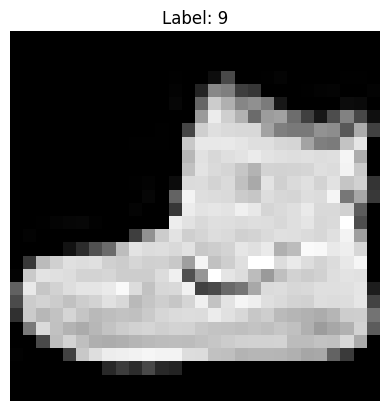

In [15]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.axis('off')
plt.show()

In [16]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

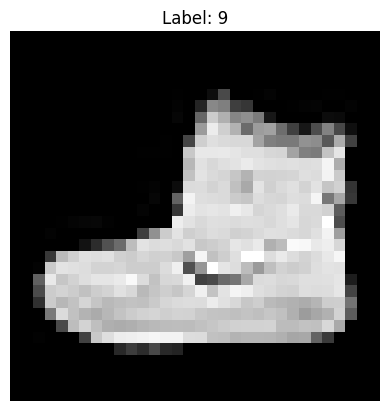

In [18]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.axis('off')
plt.show()

# 2. Encoder

In [22]:
x_train[0].shape

(32, 32, 1)

In [29]:
encoder_input = layers.Input(shape=x_train[0].shape, name='e_input')
x = layers.Conv2D(32, (3,3), 2,'same', activation = 'relu')(encoder_input)
x = layers.Conv2D(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2D(128, (3,3), 2,'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)[1:] # shape of the tensor

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='e_output')(x)

encoder = models.Model(encoder_input,encoder_output)

In [30]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_input (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 e_output (Dense)            (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [31]:
shape_before_flattening

(4, 4, 128)

In [34]:
np.prod(shape_before_flattening) == 4*4*128

True

# 3. Decoder

In [37]:
decoder_input = layers.Input(shape=(2,), name='d_input')
x = layers.Dense(np.prod(shape_before_flattening) )(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(32, (3,3), 2,'same', activation = 'relu')(x)
decoder_output = layers.Conv2D(1,(3,3), 1, 'same', activation = 'sigmoid',name='d_output')(x)
decoder = models.Model(decoder_input, decoder_output)

In [38]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

# 4. Autoencoder

In [41]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

In [42]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_input (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 e_output (Dense)            (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [ ]:
#binary_crossentropy

In [43]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [44]:
model_history = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [47]:
autoencoder.fit(
    x_train,
    x_train,
    epochs = 3,
    batch_size=100,
    shuffle=True,
    validation_data=(x_train,x_train),
    callbacks=[model_history, tensorboard_callback]
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2979INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 106s 172ms/step - loss: 0.2979 - val_loss: 0.2607
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2570INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 101s 167ms/step - loss: 0.2570 - val_loss: 0.2542
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2532INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 101s 168ms/step - loss: 0.2532 - val_loss: 0.2518


In [48]:
example_images = x_test[:50]
predictions = autoencoder.predict(example_images)

2/2 [==============================] - 0s 15ms/step


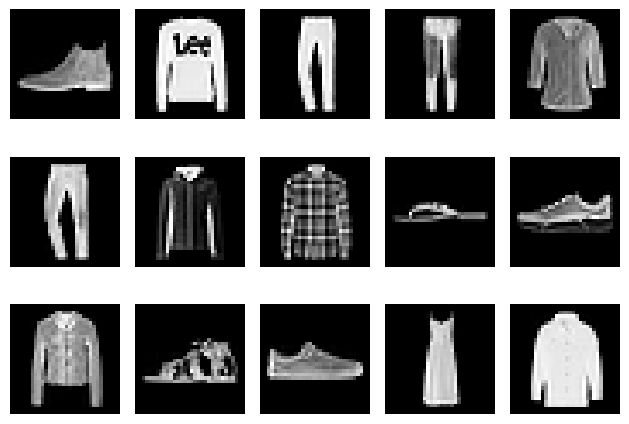

In [60]:
for i in range(15):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


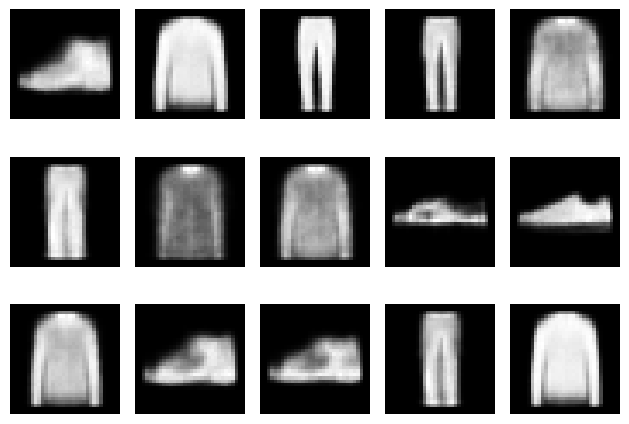

In [61]:
for i in range(15):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(predictions[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [62]:
# experiment

In [68]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [69]:
autoencoder_test = models.Model(encoder_input, decoder(encoder_output))
autoencoder_test.compile(optimizer="adam", loss=rmse)

In [70]:
autoencoder_test.fit(
    x_train,
    x_train,
    epochs = 3,
    batch_size=100,
    shuffle=True,
    validation_data=(x_train,x_train)
)

Epoch 1/3
600/600 [==============================] - 99s 163ms/step - loss: 0.1508 - val_loss: 0.1495
Epoch 2/3
600/600 [==============================] - 99s 165ms/step - loss: 0.1491 - val_loss: 0.1480
Epoch 3/3
600/600 [==============================] - 98s 163ms/step - loss: 0.1477 - val_loss: 0.1467


In [72]:
example_images = x_test[:50]
predictions_t = autoencoder_test.predict(example_images)

2/2 [==============================] - 0s 12ms/step


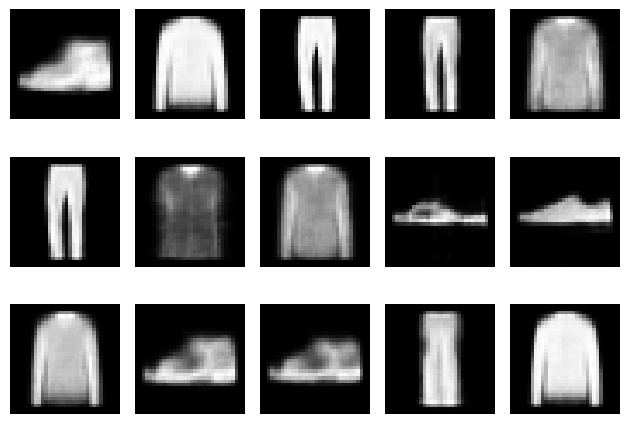

In [73]:
for i in range(15):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(predictions_t[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
